# Ungraded Lab: Using Convolutional Neural Networks

In this lab, you will look at another way of building your text classification model and this will be with a convolution layer. As you learned in Course 2 of this specialization, convolutions extract features by applying filters to the input. Let's see how you can use that for text data in the next sections.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import keras_nlp

## Download and prepare the dataset

In [2]:
# The dataset is already downloaded for you. For downloading you can use the code below.
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="../data/", download=False)

In [3]:
# Extract the train reviews and labels
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

# Extract the test reviews and labels
test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

In [4]:
# Download the subword vocabulary
!wget https://storage.googleapis.com/tensorflow-1-public/course3/imdb_vocab_subwords.txt

/usr/bin/sh: 1: wget: not found


In [5]:
# Initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./imdb_vocab_subwords.txt'
)

In [6]:
# Data pipeline and padding parameters
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 256
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [7]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), truncating=TRUNC_TYPE, padding=PADDING_TYPE)

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [8]:
# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

## Build the Model

In Course 2, you were using 2D convolution layers because you were applying it on images. For temporal data such as text sequences, you will use [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) instead so the convolution will happen over a single dimension. You will also append a pooling layer to reduce the output of the convolution layer. For this lab, you will use [GlobalMaxPooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) to get the max value across the time dimension. You can also use average pooling and you will do that in the next labs. See how these layers behave as standalone layers in the cell below.

In [9]:
# Parameters
BATCH_SIZE = 1
TIMESTEPS = 20
FEATURES = 20
FILTERS = 128
KERNEL_SIZE = 5
#since this is a seq2seq when conv applied it is applied on 1D using conv1D and globalmaxpool1D
print(f'batch_size: {BATCH_SIZE}')
print(f'timesteps (sequence length): {TIMESTEPS}')
print(f'features (embedding size): {FEATURES}')
print(f'filters: {FILTERS}')
print(f'kernel_size: {KERNEL_SIZE}')

# Define array input with random values
random_input = np.random.rand(BATCH_SIZE,TIMESTEPS,FEATURES)
print(f'shape of input array: {random_input.shape}')#(1,20,20) says 20 as the seq length(timestamps) and 20 is the embedding dimension(features)

# Pass array to convolution layer and inspect output shape
conv1d = tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu')
result = conv1d(random_input)
print(f'shape of conv1d output: {result.shape}')#(1,16,128) so the 128 will be the filters applied so so much 16 because of the clpping and here filter 5 means applied at 5 words at a time
#clipping is same formula of (20-5+2P(padding is 0)/1(stride is 1) +1 ) so we get 16 and then depth is of filters applied i.e 128
# Pass array to max pooling layer and inspect output shape
gmp = tf.keras.layers.GlobalMaxPooling1D()
result = gmp(result)
print(f'shape of global max pooling output: {result.shape}')#(1,128) so for all 16 takes one(the max value and gives) for each 128 if avg would do the avg and give

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 20
filters: 128
kernel_size: 5
shape of input array: (1, 20, 20)
shape of conv1d output: (1, 16, 128)
shape of global max pooling output: (1, 128)


## BASIC EMBEDDING UNDERSTANDING
When using an embedding layer in an RNN model, the embedding process converts each word in the sequence to a vector of the specified embedding dimension, not the entire sentence at once. 

### Explanation of How Embedding Works:
- If your input sequence length is **120** (i.e., the sentence has 120 words), and you specify the embedding dimension as, say, **64**, the embedding layer will convert each of those 120 words into a **64-dimensional** vector.
- As a result, after the embedding layer, your sentence of length 120 will be represented as a **matrix of shape `(120, 64)`**, where:
  - **120** is the number of words (sequence length).
  - **64** is the embedding dimension (the size of each word vector).

### Workflow with Embedding in RNN:
- Suppose you pass a batch of sentences, each with a sequence length of 120.
- The embedding layer will transform each word in those sequences into vectors of size 64, producing a batch of matrices.
- The output from the embedding layer will have the shape **`(batch_size, sequence_length, embedding_dim)`**, where:
  - **`batch_size`** is the number of sentences in the batch.
  - **`sequence_length`** is the maximum number of words in each sentence (120 in this case).
  - **`embedding_dim`** is the size of the word vector (64 in this case).

### Example:
- Let's say `batch_size = 32`, `sequence_length = 120`, and `embedding_dim = 64`.
- The input to the embedding layer will be of shape **`(32, 120)`** (batch of 32 sentences, each with 120 words).
- The output of the embedding layer will be of shape **`(32, 120, 64)`** (each word in each sentence is represented as a 64-dimensional vector).

### Feeding the Embeddings to an RNN:
- When you feed these embeddings to an RNN, LSTM, or GRU, the model will process each word's vector representation in the sequence one step at a time.
- The RNN will consider the sequential nature of the data and use the word vectors to learn dependencies between words in the sentence.

### Why This is Important:
- By converting each word to a vector, the embedding layer helps the RNN model understand the semantic meaning of the words in the context of the sentence.
- The sequence of word vectors allows the RNN to capture dependencies between words over time, which is essential for tasks like sentiment analysis, language modeling, or machine translation.

### Summary:
- The **embedding layer** converts each word in the sequence to a fixed-size vector, not the entire sentence at once.
- The RNN processes these word vectors step by step to learn the relationships and patterns in the data.

This approach helps the model learn the structure and meaning of the sentences more effectively.

In [10]:
# so at a time the lstm takes the embedding of the word as input and would give as the output based on the units whic it has so total that many units as the output for each word
#so if no return seq i.e set to false then only the output for the last word so dimentsion will be only (1,no of lstms) if set to true then for each word the no of lstm as output we get

You can build the model by simply appending the convolution and pooling layer after the embedding layer as shown below.

In [11]:
# Hyperparameters
EMBEDDING_DIM = 64
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 64

# Build the model using the cnn
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       488,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,049 (2.05 MB)

 Trainable params: 538,049 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

Training will take around 30 seconds per epoch and you will notice that it reaches higher accuracies than the previous models you've built.

In [13]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10


I0000 00:00:1728272336.751103    2746 service.cc:145] XLA service 0x77f4fc247da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728272336.751333    2746 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6


 3/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5319 - loss: 0.6919 

I0000 00:00:1728272342.559626    2746 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.5832 - loss: 0.6631 - val_accuracy: 0.8194 - val_loss: 0.4101
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8425 - loss: 0.3524 - val_accuracy: 0.8890 - val_loss: 0.2672
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9221 - loss: 0.2003 - val_accuracy: 0.8938 - val_loss: 0.2582
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9600 - loss: 0.1187 - val_accuracy: 0.8771 - val_loss: 0.3182
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9737 - loss: 0.0817 - val_accuracy: 0.8906 - val_loss: 0.2983
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9794 - loss: 0.0596 - val_accuracy: 0.8828 - val_loss: 0.3609
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9919 - loss: 0.0301 - val_accuracy: 0.8950 - val_loss: 0.3160
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9996 - loss: 0.0079 - val_accuracy: 0.8954 - val_loss: 

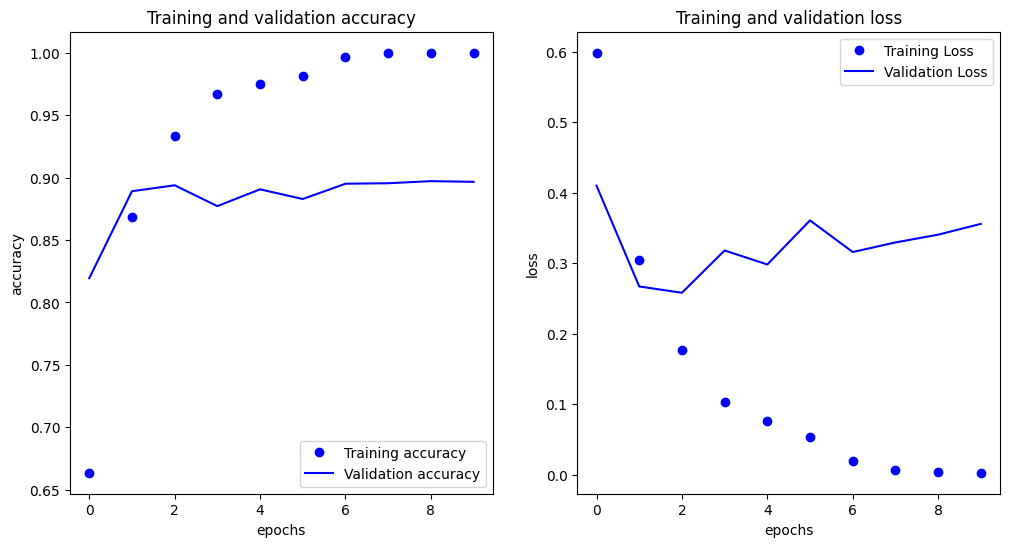

In [14]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

## Wrap Up

In this lab, you explored another model architecture you can use for text classification. In the next lessons, you will revisit full word encoding of the IMDB reviews and compare which model works best when the data is prepared that way.

As before, run the cell below to free up resources.

In [15]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}